## 1.2 Milvus 安装实战
在上一节中，我们学习了向量数据库 Milvus 的基本概念。现在，我们将进行 Milvus 安装实战。

### 云端使用介绍

在学习 Milvus 向量数据库时，除了本地 Milvus Lite、单机版 Milvus Standalone 或 Milvus on K8s 之外，还可以选择 Zilliz Cloud —— 一种无需部署服务器、零成本上手的托管方案。下面将演示如何申请 Zilliz Cloud 中国区免费套餐并运行官方示例代码。


#### 注册并创建免费集群

1. 打开官网

   - 国内站点：https://zilliz.com.cn/
   - 海外站点：https://zilliz.com/

我们本次实验使用的是国内站点，部署在阿里云，目前可以免费使用。

   ![a508309b90c710ffd1d9e998626c47f9](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/a508309b90c710ffd1d9e998626c47f9.png)

2. 选择 **手机号码** 或 **邮箱** 登录/注册。

   ![image-20250626212403361](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/image-20250626212403361.png)

3. 进入控制台首页后，点击 **Create Cluster** 按钮。
   ![起始页面](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/d712d4c4fd8f2546dab4426c68bf806f.png)

4. 在弹窗中选择 **Free Tier**（免费套餐），数据中心默认为 **阿里云 · 杭州**。
   ![选择免费集群](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/25626960ddcd05d12117aff485eb2487.png)

5. 等待几分钟，集群创建完成后会显示 **Endpoint URI、API Token、Cluster ID** 等信息，请妥善保存。
   ![集群信息](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/3d606a5a0a797d7332bbb3efd86fd8c4.png)

6. 运行中

![395f581c7dbbeb8b4940afa0bcab025a](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/395f581c7dbbeb8b4940afa0bcab025a.png)

安装milvus-cli：

In [ ]:
!pip install uv
!uv pip install milvus-cli




终端执行 milvus_cli，进入交互式 CLI

```bash
milvus_cli                                                                                                         



  __  __ _ _                    ____ _     ___
 |  \/  (_) |_   ___   _ ___   / ___| |   |_ _|
 | |\/| | | \ \ / / | | / __| | |   | |    | |
 | |  | | | |\ V /| |_| \__ \ | |___| |___ | |
 |_|  |_|_|_| \_/  \__,_|___/  \____|_____|___|

Milvus cli version: 1.0.2
Pymilvus version: 2.5.3

Learn more: https://github.com/zilliztech/milvus_cli.


milvus_cli > connect -uri https://in03-d7b5690fee7bcbf.serverless.ali-cn-hangzhou.cloud.zilliz.com.cn -t 88b738ee492b2ad88d69c166ee587825d546b049dab3a5d8767733a636efec52a62e96b283ab90c24146d5a311696dacd9499fc1
Connect Milvus successfully.
+---------+---------+
| Address |         |
|  Alias  | default |
+---------+---------+
milvus_cli > list databases
+--------------------+
|      db_name       |
+--------------------+
| db_d7b5690fee7bcbf |
+--------------------+
```



####  创建虚拟环境（缺少 3.12 时 uv 会自动下载）

```
uv venv milvus-py --python 3.12

# 激活环境
source milvus-py/bin/activate      # macOS / Linux
# .\milvus-py\Scripts\activate      # Windows PowerShell

```

如果你使用的是 conda 也可以：

```bash
conda create -n milvus-py python==3.12 -y
conda activate milvus-py
```

1. **克隆仓库**
```bash
git clone https://github.com/zilliztech/cloud-vectordb-examples.git
```

如果由于网络问题无法下载可以从后面复制代码


1. **安装 PyMilvus**

```bash
pip3 install pymilvus==2.5.3
```

1. **进入 Python 示例目录**

```bash
cd cloud-vectordb-examples/python


```

需要注意的是，在开源版本的 Milvus 中，端口号是9530 / 9091 ，而在Zilliz cloud 上，端口上是 443.


完整代码如下，我们需要一个 Python 文件和一个用于存放Zilliz凭证的ini配置文件。

在工程文件夹新建 `config.ini` ，然后填入你的集群信息（务必保持格式），⚠️ 切勿把 API Key 提交到公开仓库。

```ini
uri = https://<your-endpoint>
token = <your-api-key>
```

In [12]:
import configparser
import time
import random

from pymilvus import MilvusClient
from pymilvus import DataType

cfp = configparser.RawConfigParser()
cfp.read('config.ini')
milvus_uri = cfp.get('example', 'uri')
token = cfp.get('example', 'token')

milvus_client = MilvusClient(uri=milvus_uri, token=token)
print(f"Connected to DB: {milvus_uri} successfully")


# Check if the collection exists
collection_name = "book"
check_collection = milvus_client.has_collection(collection_name)

if check_collection:
    milvus_client.drop_collection(collection_name)
    print(f"Dropped the existing collection {collection_name} successfully")

dim = 64

print("Start to create the collection schema")
schema = milvus_client.create_schema()
schema.add_field("book_id", DataType.INT64, is_primary=True, description="customized primary id")
schema.add_field("word_count", DataType.INT64, description="word count")
schema.add_field("book_intro", DataType.FLOAT_VECTOR, dim=dim, description="book introduction")
print("Start to prepare index parameters with default AUTOINDEX")
index_params = milvus_client.prepare_index_params()
index_params.add_index("book_intro", metric_type="L2")

print(f"Start to create example collection: {collection_name}")
# create collection with the above schema and index parameters, and then load automatically
milvus_client.create_collection(collection_name, schema=schema, index_params=index_params)
collection_property = milvus_client.describe_collection(collection_name)
print("Collection details: %s" % collection_property)

# insert data with customized ids
nb = 1000
insert_rounds = 2
start = 0           # first primary key id
total_rt = 0        # total response time for inert

print(f"Start to insert {nb*insert_rounds} entities into example collection: {collection_name}")
for i in range(insert_rounds):
    vector = [random.random() for _ in range(dim)]
    rows = [{"book_id": i, "word_count": random.randint(1, 100), "book_intro": vector} for i in range(start, start+nb)]
    t0 = time.time()
    milvus_client.insert(collection_name, rows)
    ins_rt = time.time() - t0
    start += nb
    total_rt += ins_rt
print(f"Insert completed in {round(total_rt,4)} seconds")

print("Start to flush")
start_flush = time.time()
milvus_client.flush(collection_name)
end_flush = time.time()
print(f"Flush completed in {round(end_flush - start_flush, 4)} seconds")

# search
nq = 3
search_params = {"metric_type": "L2",  "params": {"level": 2}}
limit = 2

for i in range(5):
   search_vectors = [[random.random() for _ in range(dim)] for _ in range(nq)]
   t0 = time.time()
   results = milvus_client.search(collection_name,
                                  data=search_vectors,
                                  limit=limit,
                                  search_params=search_params,
                                  anns_field="book_intro")
   t1 = time.time()
   assert len(results) == nq
   assert len(results[0]) == limit
   print(f"Search {i} results: {results}")
   print(f"Search {i} latency: {round(t1-t0, 4)} seconds")

Connected to DB: https://in03-d7b5690fee7bcbf.serverless.ali-cn-hangzhou.cloud.zilliz.com.cn successfully
Dropped the existing collection book successfully
Start to create the collection schema
Start to prepare index parameters with default AUTOINDEX
Start to create example collection: book
Collection details: {'collection_name': 'book', 'auto_id': False, 'num_shards': 1, 'description': '', 'fields': [{'field_id': 100, 'name': 'book_id', 'description': 'customized primary id', 'type': <DataType.INT64: 5>, 'params': {}, 'is_primary': True}, {'field_id': 101, 'name': 'word_count', 'description': 'word count', 'type': <DataType.INT64: 5>, 'params': {}}, {'field_id': 102, 'name': 'book_intro', 'description': 'book introduction', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 64}}], 'functions': [], 'aliases': [], 'collection_id': 457861707876945551, 'consistency_level': 2, 'properties': {}, 'num_partitions': 1, 'enable_dynamic_field': False}
Start to insert 2000 entities into exam

运行示例脚本

```bash
python3 hello_zilliz_vectordb.py
```

运行后可见类似输出：

```
Connected to DB: https://in03-d7b5690fee7bcbf.serverless.ali-cn-hangzhou.cloud.zilliz.com.cn successfully
Start to create the collection schema
Start to prepare index parameters with default AUTOINDEX
Start to create example collection: book
Collection details: {'collection_name': 'book', 'auto_id': False, 'num_shards': 1, 'description': '', 'fields': [{'field_id': 100, 'name': 'book_id', 'description': 'customized primary id', 'type': <DataType.INT64: 5>, 'params': {}, 'is_primary': True}, {'field_id': 101, 'name': 'word_count', 'description': 'word count', 'type': <DataType.INT64: 5>, 'params': {}}, {'field_id': 102, 'name': 'book_intro', 'description': 'book introduction', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 64}}], 'functions': [], 'aliases': [], 'collection_id': 457861707686138665, 'consistency_level': 2, 'properties': {}, 'num_partitions': 1, 'enable_dynamic_field': False}
Start to insert 2000 entities into example collection: book
Insert completed in 0.692 seconds
Start to flush
Flush completed in 3.0984 seconds
Search 0 results: data: ["[{'id': 0, 'distance': 10.547525405883789, 'entity': {}}, {'id': 1, 'distance': 10.547525405883789, 'entity': {}}]", "[{'id': 0, 'distance': 8.913854598999023, 'entity': {}}, {'id': 1, 'distance': 8.913854598999023, 'entity': {}}]", "[{'id': 1000, 'distance': 9.11572551727295, 'entity': {}}, {'id': 1001, 'distance': 9.11572551727295, 'entity': {}}]"] , extra_info: {'cost': 6}
Search 0 latency: 3.4933 seconds
Search 1 results: data: ["[{'id': 0, 'distance': 8.898500442504883, 'entity': {}}, {'id': 1, 'distance': 8.898500442504883, 'entity': {}}]", "[{'id': 0, 'distance': 9.7216157913208, 'entity': {}}, {'id': 1, 'distance': 9.7216157913208, 'entity': {}}]", "[{'id': 1000, 'distance': 8.997819900512695, 'entity': {}}, {'id': 1001, 'distance': 8.997819900512695, 'entity': {}}]"] , extra_info: {'cost': 6}
Search 1 latency: 0.099 seconds
Search 2 results: data: ["[{'id': 0, 'distance': 7.597465515136719, 'entity': {}}, {'id': 1, 'distance': 7.597465515136719, 'entity': {}}]", "[{'id': 0, 'distance': 9.255533218383789, 'entity': {}}, {'id': 1, 'distance': 9.255533218383789, 'entity': {}}]", "[{'id': 0, 'distance': 9.471370697021484, 'entity': {}}, {'id': 1, 'distance': 9.471370697021484, 'entity': {}}]"] , extra_info: {'cost': 6}
Search 2 latency: 0.0677 seconds
Search 3 results: data: ["[{'id': 1000, 'distance': 8.828998565673828, 'entity': {}}, {'id': 1001, 'distance': 8.828998565673828, 'entity': {}}]", "[{'id': 1000, 'distance': 8.66336441040039, 'entity': {}}, {'id': 1001, 'distance': 8.66336441040039, 'entity': {}}]", "[{'id': 0, 'distance': 9.222965240478516, 'entity': {}}, {'id': 1, 'distance': 9.222965240478516, 'entity': {}}]"] , extra_info: {'cost': 6}
Search 3 latency: 0.0722 seconds
Search 4 results: data: ["[{'id': 0, 'distance': 9.342487335205078, 'entity': {}}, {'id': 1, 'distance': 9.342487335205078, 'entity': {}}]", "[{'id': 0, 'distance': 6.45243501663208, 'entity': {}}, {'id': 1, 'distance': 6.45243501663208, 'entity': {}}]", "[{'id': 0, 'distance': 8.369773864746094, 'entity': {}}, {'id': 1, 'distance': 8.369773864746094, 'entity': {}}]"] , extra_info: {'cost': 6}
Search 4 latency: 0.0687 seconds
```

如果控制台显示如上日志，即表明已成功连接集群、创建 collection 并完成简单的向量检索。

------

![image-20250626211850476](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/image-20250626211850476.png)

------



然后我们就可以通过控制台来查看这个新建的索引和数据了。



![image-20250702113618025](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/image-20250702113618025.png)



除此之外，zilliz 还提供了restapi ，这样我们就可以通过请求 HTTP 来完成数据检索了。

```bash
curl --request POST \
  --url https://in03-d7b5690fee7bcbf.serverless.ali-cn-hangzhou.cloud.zilliz.com.cn/v2/vectordb/collections/list \
  --header 'accept: application/json' \
  --header 'authorization: Bearer <api-key>' \
  --data '{}'
```



Python 版本的如下，需要我们把api-key 作为 bear token 传到请求头里。

```python
import requests

url = "https://in03-d7b5690fee7bcbf.serverless.ali-cn-hangzhou.cloud.zilliz.com.cn/v2/vectordb/collections/list"

payload = "{}"
headers = {
  'Authorization': 'Bearer <api-key>'
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)
```



同样我们再 Postman 上也可以进行测试，需要注意的是，即使请求体是空的，那么也需要使用 {} 来占位。

![image-20250702112141165](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/image-20250702112141165.png)



在左侧的api-playground 中，我们可以看到更多的 API 操作，同时还可以直接在浏览器上发送请求。

![image-20250702113040640](https://raw.githubusercontent.com/cloudsmithy/picgo-imh/master/image-20250702113040640.png)



通过 Zilliz Cloud，我们可以在几分钟内获得一套托管版 Milvus 服务，免去本地运维与资源成本，非常适合作为学习、原型开发或小型应用的向量数据库后端。祝大家玩得开心！


### 本地安装方式介绍
我们可以在 Milvus Lite、Standardalone (Docker Compose)、Kubernetes 以及 Cloud Services 中运行 Milvus。
| 安装方式 | 适用场景 | 特点 |
| --- | --- | --- |
| Milvus Lite | 专为小团队原型验，适用于快速验证和资源受限的环境 <br/> 在本地系统存储几百万个向量（用于原型验证），或为单元测试和 CI/CD 寻找嵌入式向量数据库 | · 通过 Python 包管理器（pip）直接安装，无需额外依赖<br/> · Milvus 的轻量级版本 |
| Standardalone (Docker Compose) | 适用于为生产流量提供服务，或者你需要存储几百万到上亿个向量 <br/> 百万至亿级生产落地用 Standalone（图搜、商品检索） | · 一键启动所有依赖组件<br/> · 轻量级 |
| Kubernetes | 高可用、可扩展的生产环境 <br/> 上亿向量或者上千 QPS 场景推荐 Distributed | · 支持分布式部署，自动处理节点故障<br/> · 可使用 helm 快速部署 |
| Cloud Services | 无运维负担、快速上云 | · 全托管服务，自动处理扩缩容、备份和监控 |

### 实操：使用 Docker Compose 本地快速安装 Milvus Standalone
1. 下载配置文件 
    ```bash
    wget https://github.com/milvus-io/milvus/releases/download/v2.5.10/milvus-standalone-docker-compose.yml -O docker-compose.yml
    ```
2. 启动 Milvus
    ```bash
    sudo docker compose up -d
    ```   
3. 查看 docker-compose.yml
    ```yaml
    version: '3.5'

    services:
      etcd:
        container_name: milvus-etcd
        image: quay.io/coreos/etcd:v3.5.18
        environment:
          - ETCD_AUTO_COMPACTION_MODE=revision
          - ETCD_AUTO_COMPACTION_RETENTION=1000
          - ETCD_QUOTA_BACKEND_BYTES=4294967296
          - ETCD_SNAPSHOT_COUNT=50000
        volumes:
          - ${DOCKER_VOLUME_DIRECTORY:-.}/volumes/etcd:/etcd
        command: etcd -advertise-client-urls=http://etcd:2379 -listen-client-urls http://0.0.0.0:2379 --data-dir /etcd
        healthcheck:
          test: ["CMD", "etcdctl", "endpoint", "health"]
          interval: 30s
          timeout: 20s
          retries: 3
    
      minio:
        container_name: milvus-minio
        image: minio/minio:RELEASE.2023-03-20T20-16-18Z
        environment:
          MINIO_ACCESS_KEY: minioadmin
          MINIO_SECRET_KEY: minioadmin
        ports:
          - "9001:9001"
          - "9000:9000"
        volumes:
          - ${DOCKER_VOLUME_DIRECTORY:-.}/volumes/minio:/minio_data
        command: minio server /minio_data --console-address ":9001"
        healthcheck:
          test: ["CMD", "curl", "-f", "http://localhost:9000/minio/health/live"]
          interval: 30s
          timeout: 20s
          retries: 3
    
      standalone:
        container_name: milvus-standalone
        image: milvusdb/milvus:v2.5.10
        command: ["milvus", "run", "standalone"]
        security_opt:
        - seccomp:unconfined
        environment:
          ETCD_ENDPOINTS: etcd:2379
          MINIO_ADDRESS: minio:9000
        volumes:
          - ${DOCKER_VOLUME_DIRECTORY:-.}/volumes/milvus:/var/lib/milvus
        healthcheck:
          test: ["CMD", "curl", "-f", "http://localhost:9091/healthz"]
          interval: 30s
          start_period: 90s
          timeout: 20s
          retries: 3
        ports:
          - "19530:19530"
          - "9091:9091"
        depends_on:
          - "etcd"
          - "minio"
    
    networks:
      default:
        name: milvus
    ```
   从上述文件中我们可以看到有三个服务：
   + milvus-minio：作为对象存储来持久化大型文件，如索引文件和二进制日志
   + milvus-etcd：负责存储元信息的快照，比如 collection schema 信息、节点状态信息、消息消费的 checkpoint 等
   + milvus-standalone（依赖 etcd 和 minio）：构建索引、进行查询
     + 9091 为 Milvus WebUI 端口，可以使用 http://localhost:9091/webui 地址访问；
     + 19530 端口则为 Milvus 客户端连接端口，可以使用 可以使用 localhost:19530 地址访问。

### 验证安装

#### 检查 Docker 容器状态
```bash
$ sudo docker-compose ps

CONTAINER ID   IMAGE                                      COMMAND                  CREATED         STATUS                   PORTS                                                                                          NAMES
30b5205b2d06   milvusdb/milvus:v2.5.10                    "/tini -- milvus run…"   4 minutes ago   Up 4 minutes (healthy)   0.0.0.0:9091->9091/tcp, [::]:9091->9091/tcp, 0.0.0.0:19530->19530/tcp, [::]:19530->19530/tcp   milvus-standalone
3dbe7e4b9b2c   minio/minio:RELEASE.2023-03-20T20-16-18Z   "/usr/bin/docker-ent…"   4 minutes ago   Up 4 minutes (healthy)   0.0.0.0:9000-9001->9000-9001/tcp, [::]:9000-9001->9000-9001/tcp                                milvus-minio
ffd50fd62316   quay.io/coreos/etcd:v3.5.18                "etcd -advertise-cli…"   4 minutes ago   Up 4 minutes (healthy)   2379-2380/tcp                                                                                  milvus-etcd
```

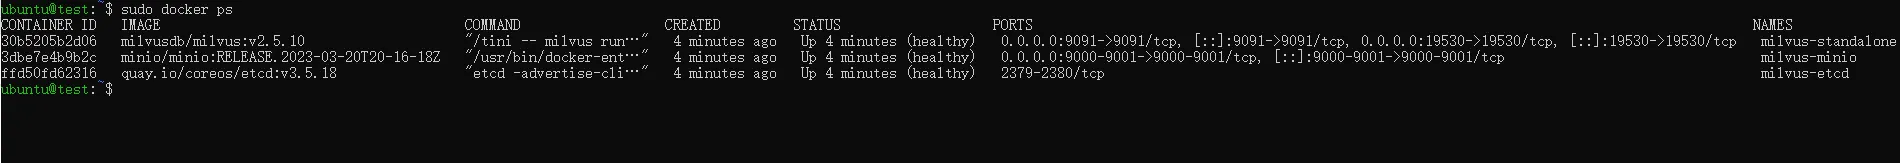

#### Milvus SDKs 概览
Milvus 提供了多种官方支持的 SDK（Python、Node.js、Go 和 Java），覆盖主流编程语言，方便开发者快速集成向量搜索功能到应用中。
| SDK | 特点 |
| --- | --- |
| Python |  PyMilvus，最成熟、最常用的 SDK，用于与 Milvus 通信、创建集合、插入/查询/搜索向量。   |
| Node.js |  Node.js 应用或前后端协作项目。 |
| Go |  用于构建高性能 Go 应用程序；轻量级，适合集成到 Kubernetes 或 Serverless 环境。 |
| Java |  适用于 Java 后端服务，如 Spring Boot 应用集成。 |

#### 连接测试
可以使用 milvus_cli 或 Python SDK 进行连接测试：
milvus_cli
+ [安装](https://milvus.io/docs/zh/install_cli.md)：

In [ ]:
pip install milvus-cli

+ 连接测试：
```bash
milvus_cli > connect -uri http://localhost:19530
```
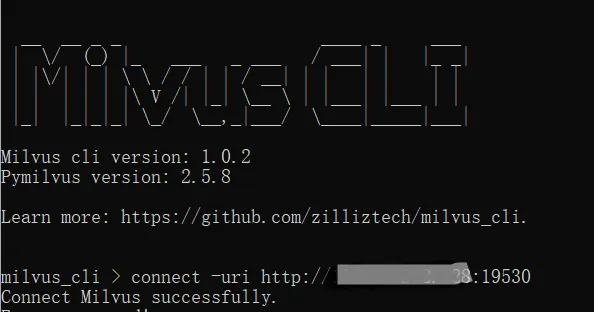

+ Python SDK

In [ ]:
from pymilvus import MilvusClient

# 连接到 Milvus 服务
# MilvusClient uses a URI or host/port for connection.
MILVUS_HOST = "localhost" # 或者你的 Milvus 服务器 IP
MILVUS_PORT = "19530"
MILVUS_URI = f"http://{MILVUS_HOST}:{MILVUS_PORT}" # Recommended format

# 或者，如果你有用户名和密码 (for Zilliz Cloud or Milvus with auth)
# MILVUS_USER = "username"
# MILVUS_PASSWORD = "password"
# client = MilvusClient(uri=MILVUS_URI, user=MILVUS_USER, password=MILVUS_PASSWORD)

try:
    # 创建 MilvusClient 实例
    client = MilvusClient(
        uri=MILVUS_URI
        # token="YOUR_API_KEY_OR_TOKEN" # For Zilliz Cloud serverless or other token-based auth
        # db_name="default" # Specify database if not default (Milvus 2.2.9+)
    )
    print(f"成功创建 MilvusClient 并连接到 Milvus 服务: {MILVUS_URI}")
    print(f"Milvus server version (via client): {client.get_server_version()}")
except Exception as e:
    print(f"创建 MilvusClient 或连接 Milvus 服务失败: {e}")

```bash
成功创建 MilvusClient 并连接到 Milvus 服务: http://localhost:19530
Milvus server version (via client): 2.5.10
```

#### WebUI 介绍
Milvus Web UI 是 Milvus 的图形化管理工具，它是一个内置工具，以简单直观的界面提供整体系统可观察性。

浏览器访问 http://localhost:9091/webui

+ 在 Home 页面，可以查看当前运行的 Milvus 实例、其组件、连接的客户端和依赖关系的信息。
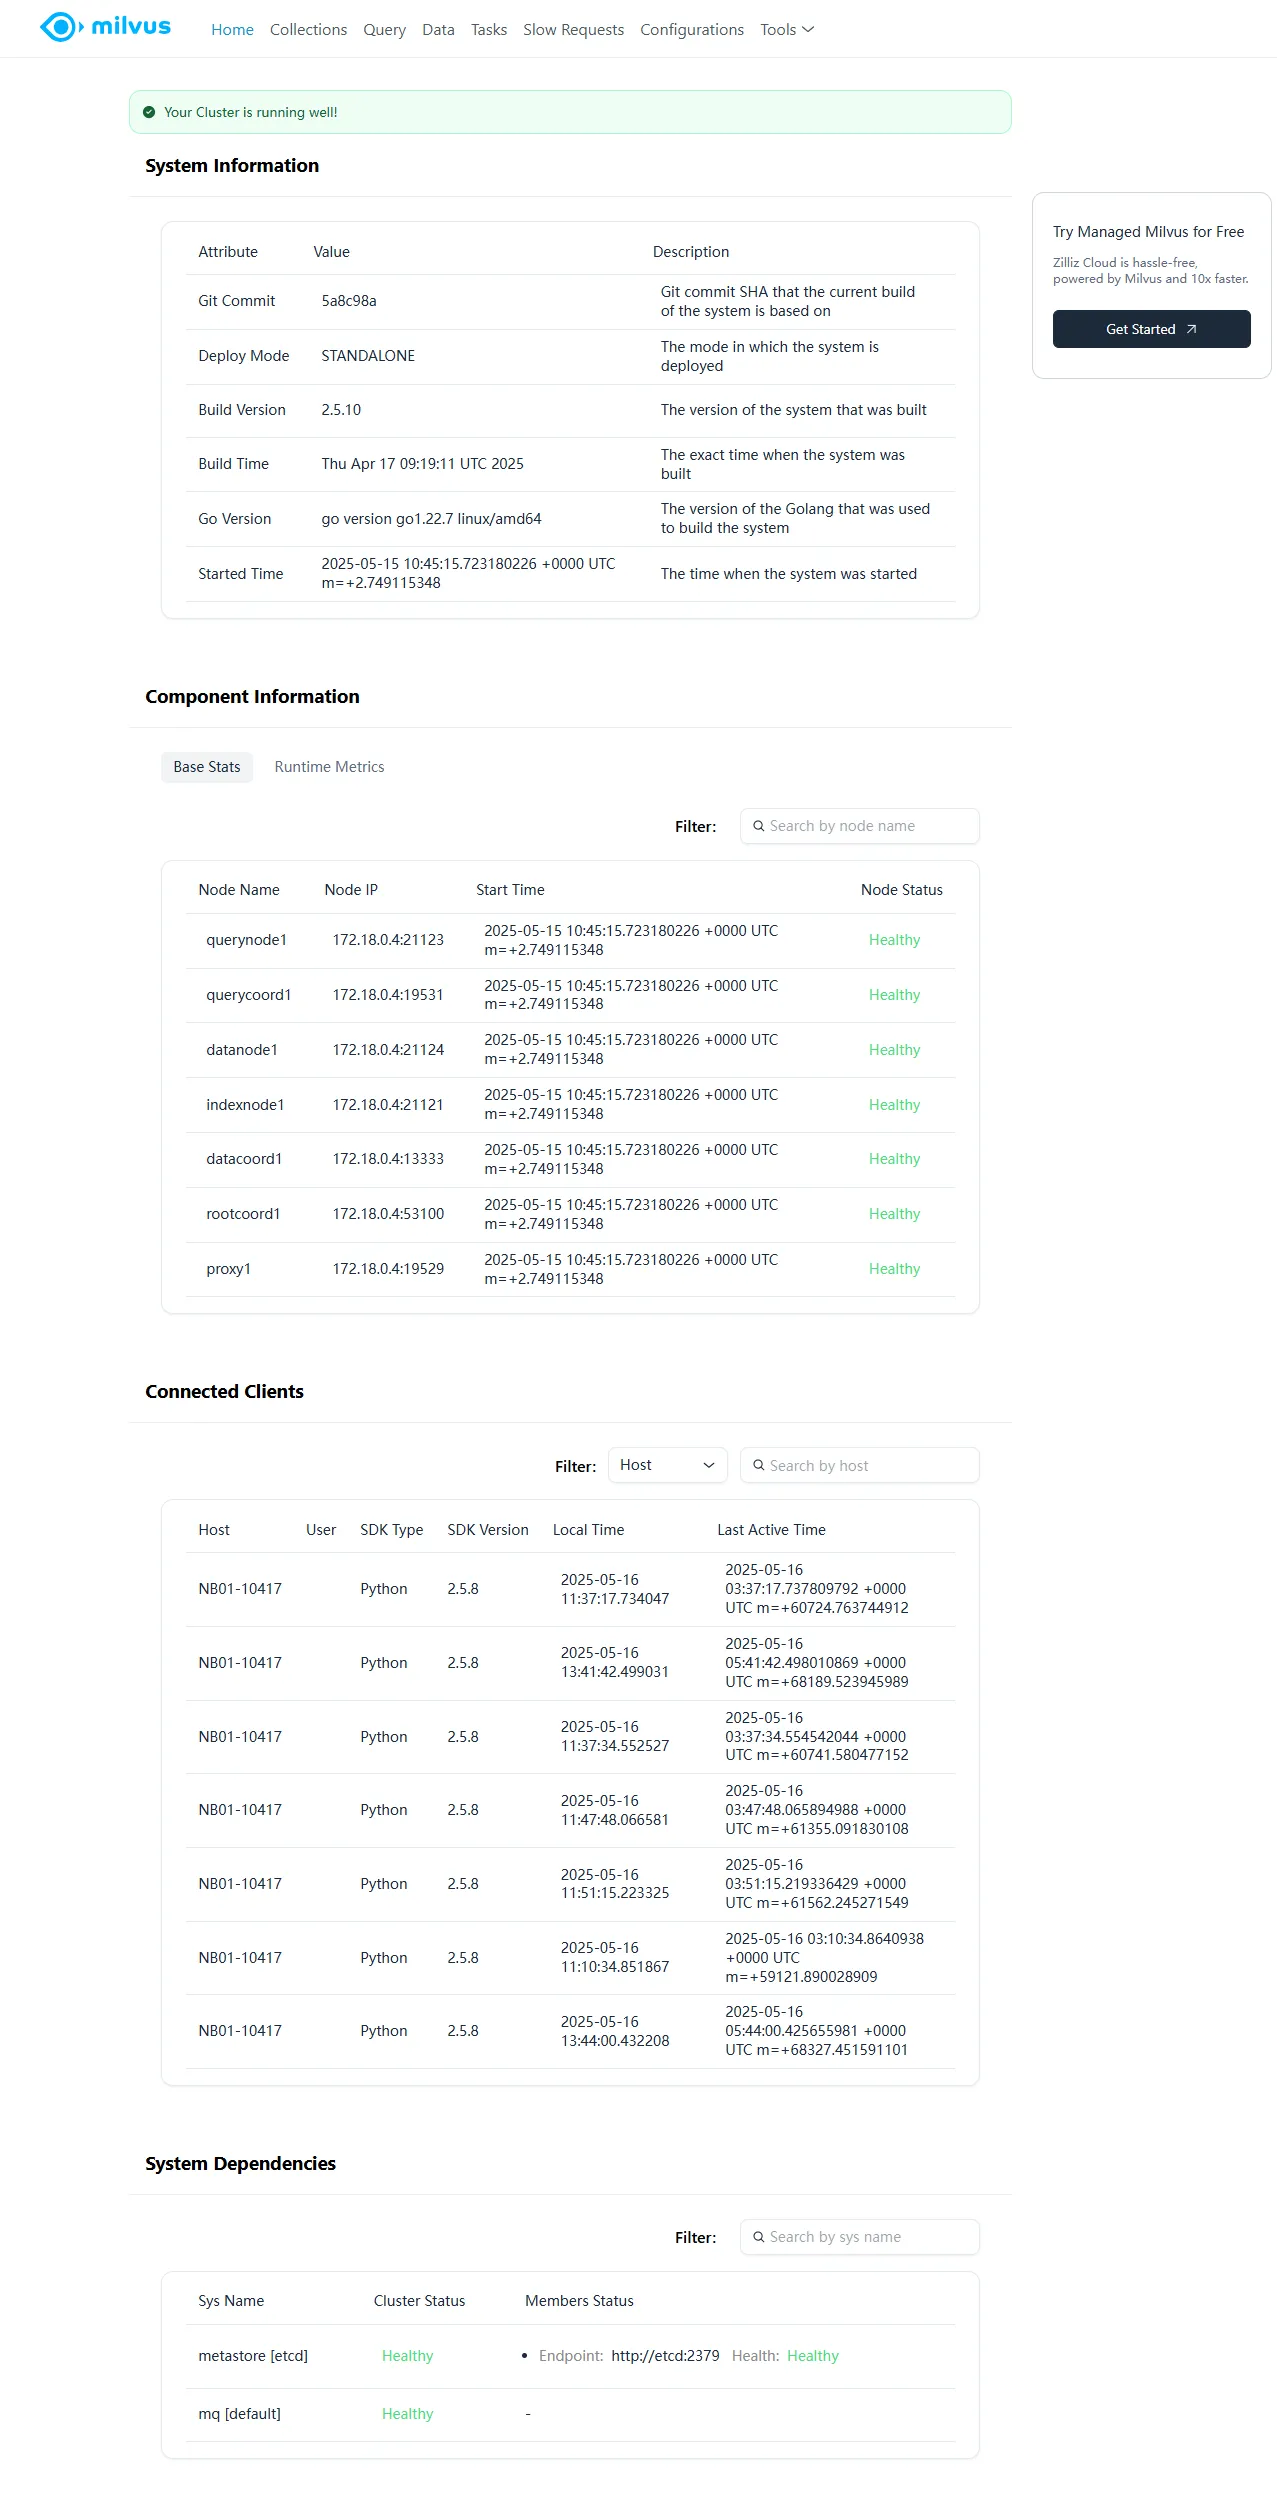

+ 在 Collections 页面，可以查看当前数据库和 Collections 列表，并检查它们的详细信息。
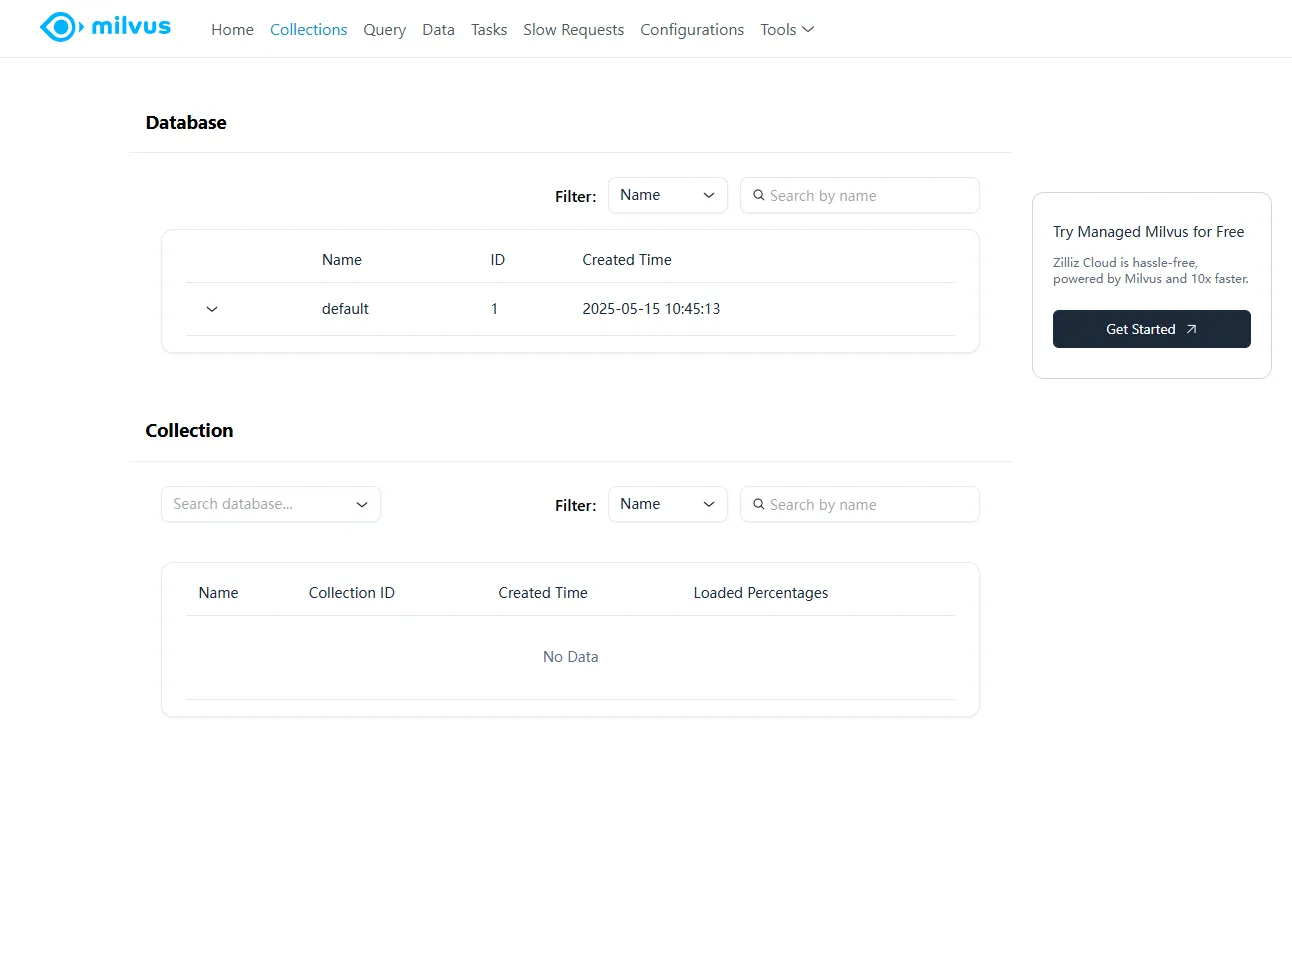

+ 在 Query 页面，可以查看分段、通道、副本和资源组列表及其详细信息。
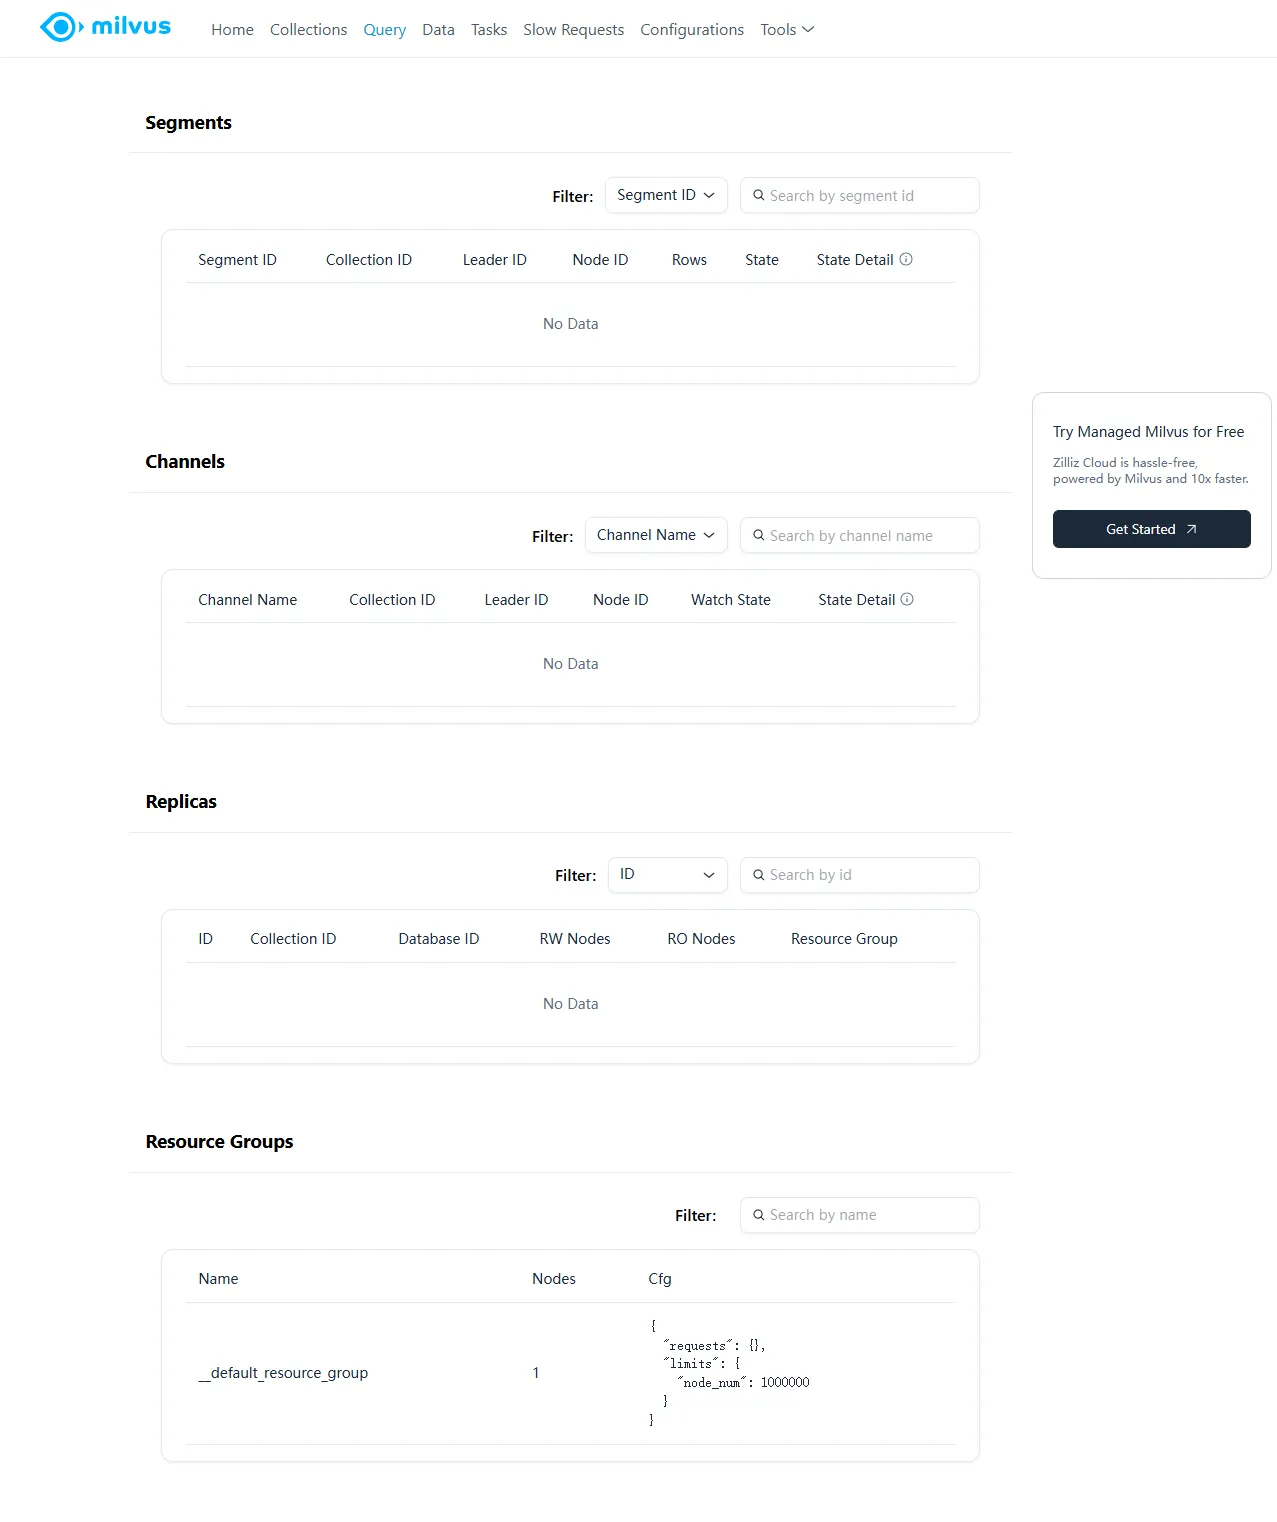

+ 在 Data 页面，可以查看数据节点/协调器的分段和通道的列表及其详细信息。
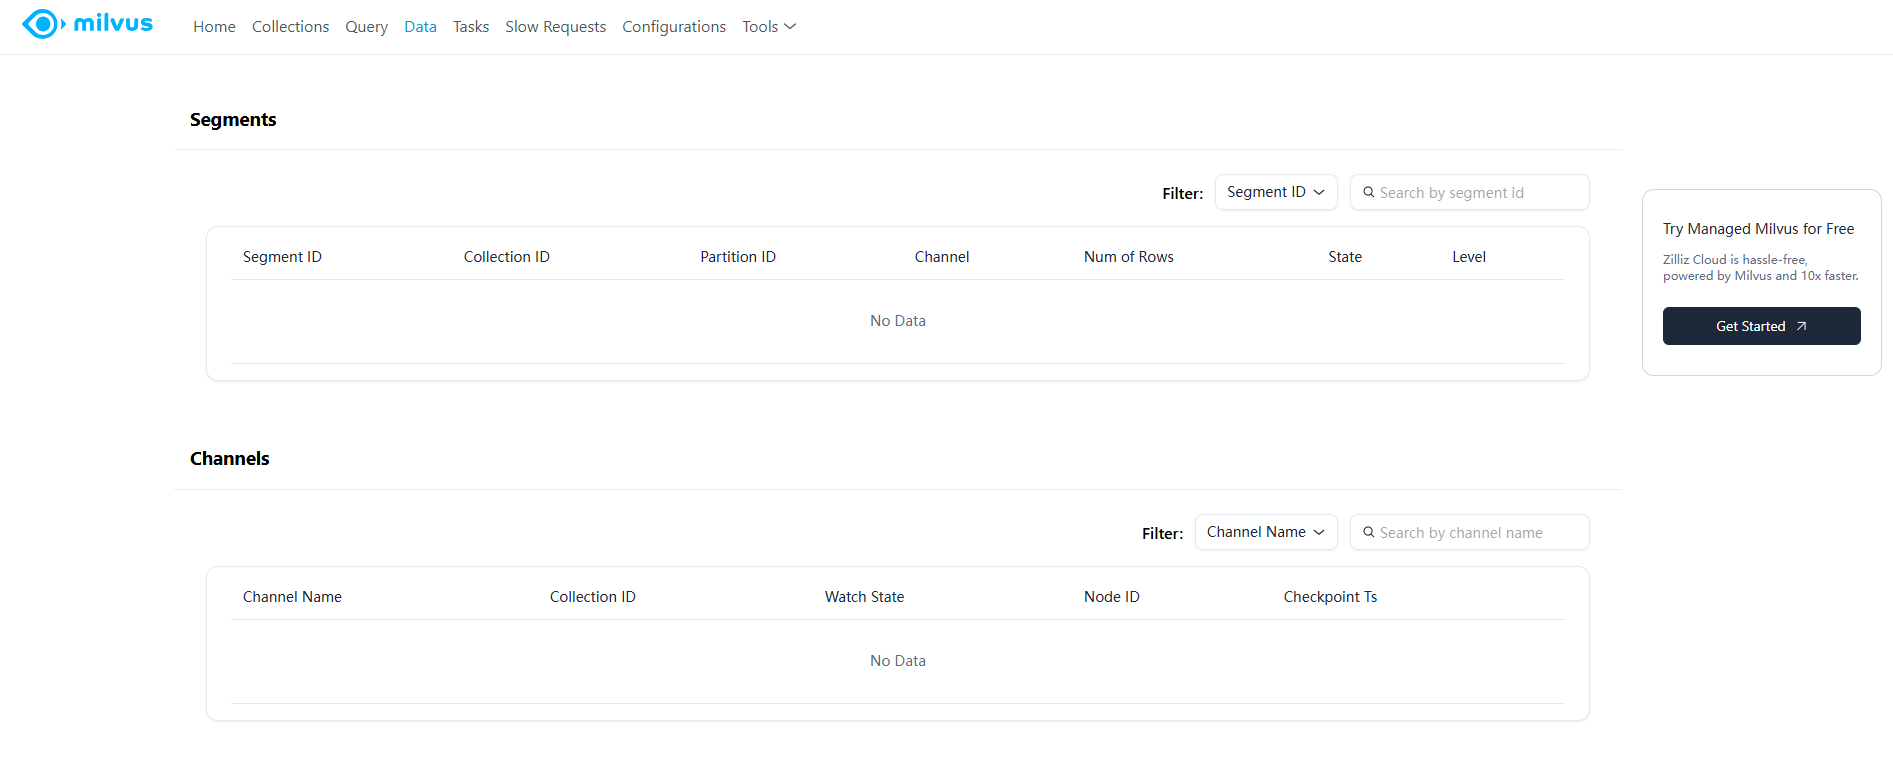

+ 在 Tasks 页面，可以查看在 Milvus 中运行的任务列表，包括任务类型、状态和操作。
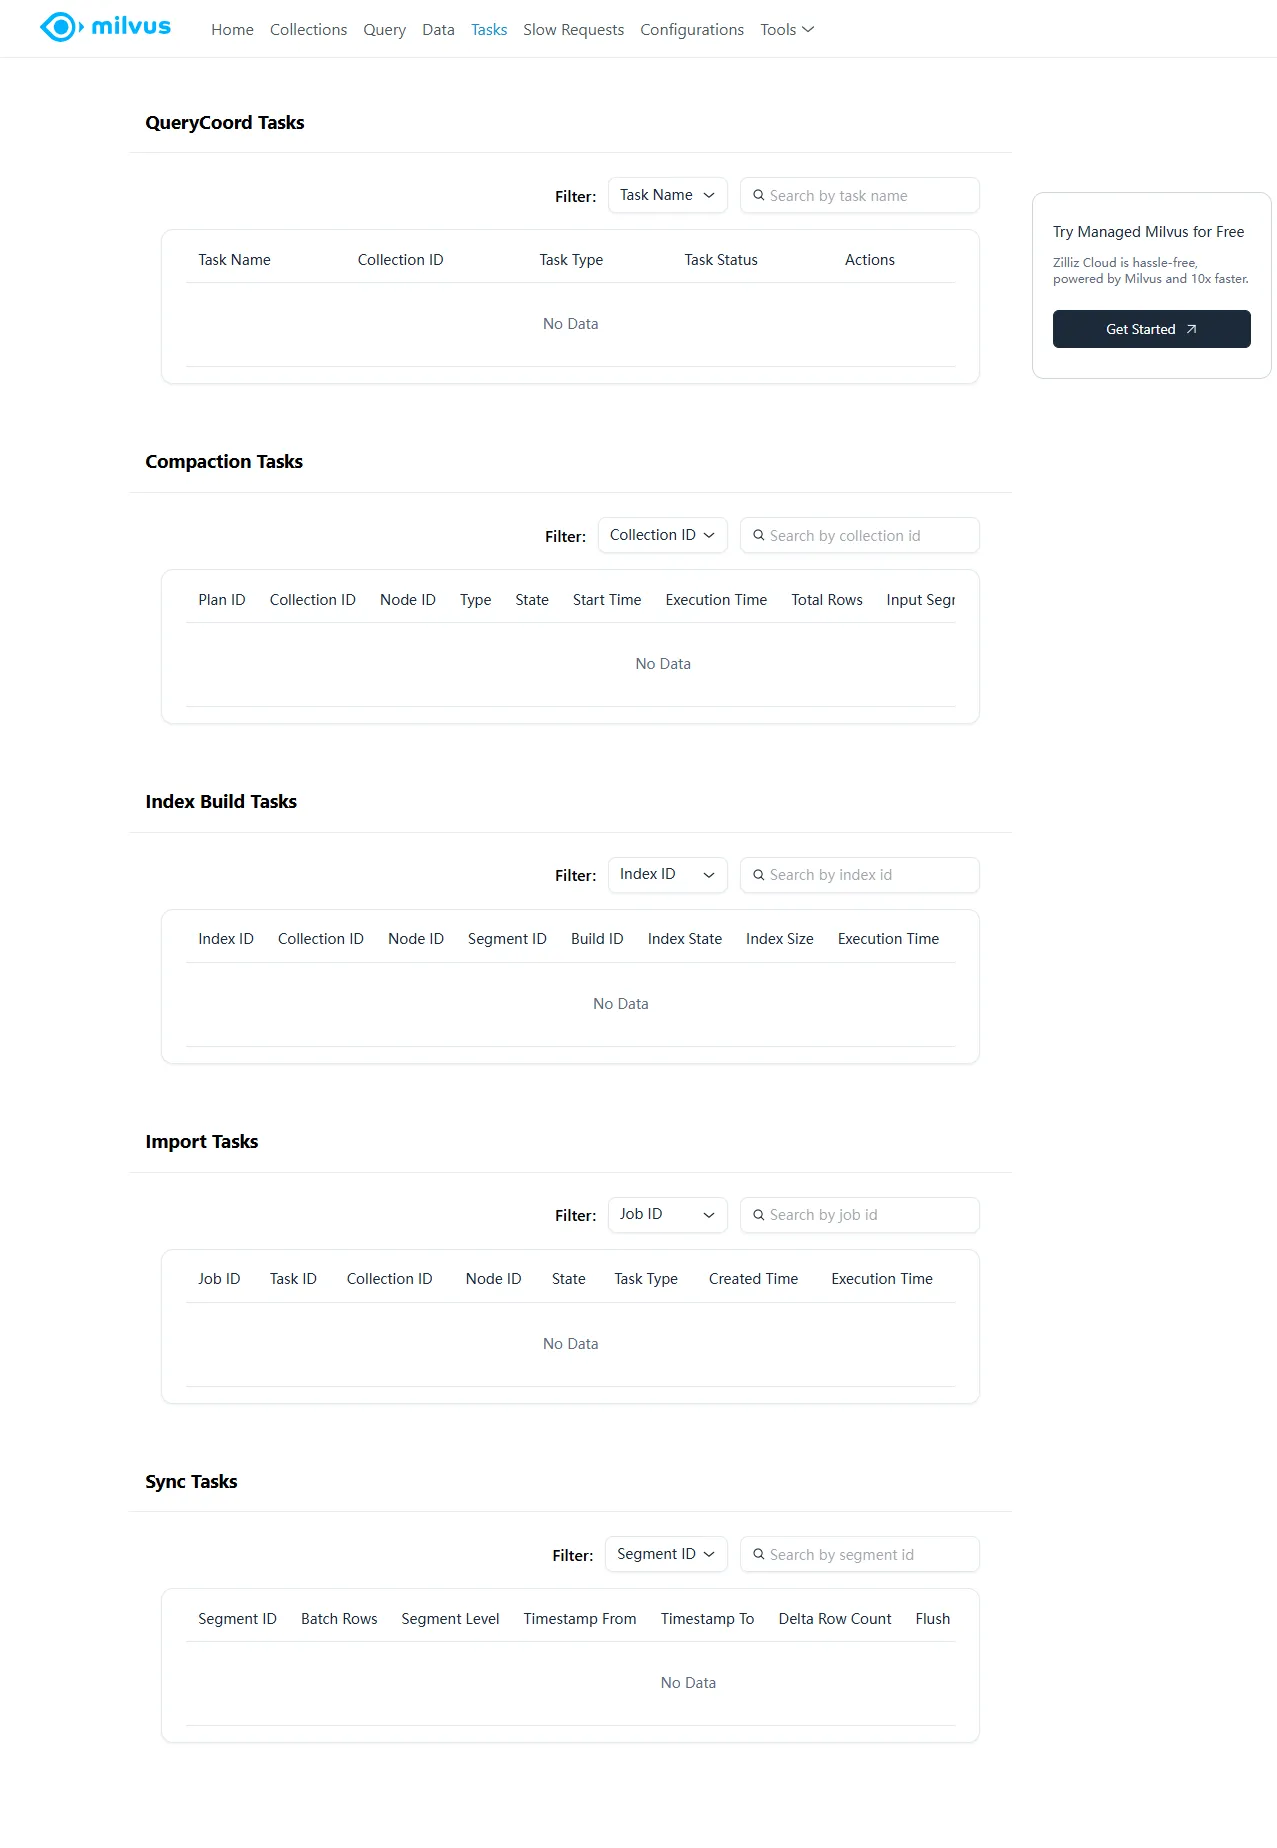

+ 在 Slow Requests 页面，显示最近 5 分钟内的所有慢速请求。
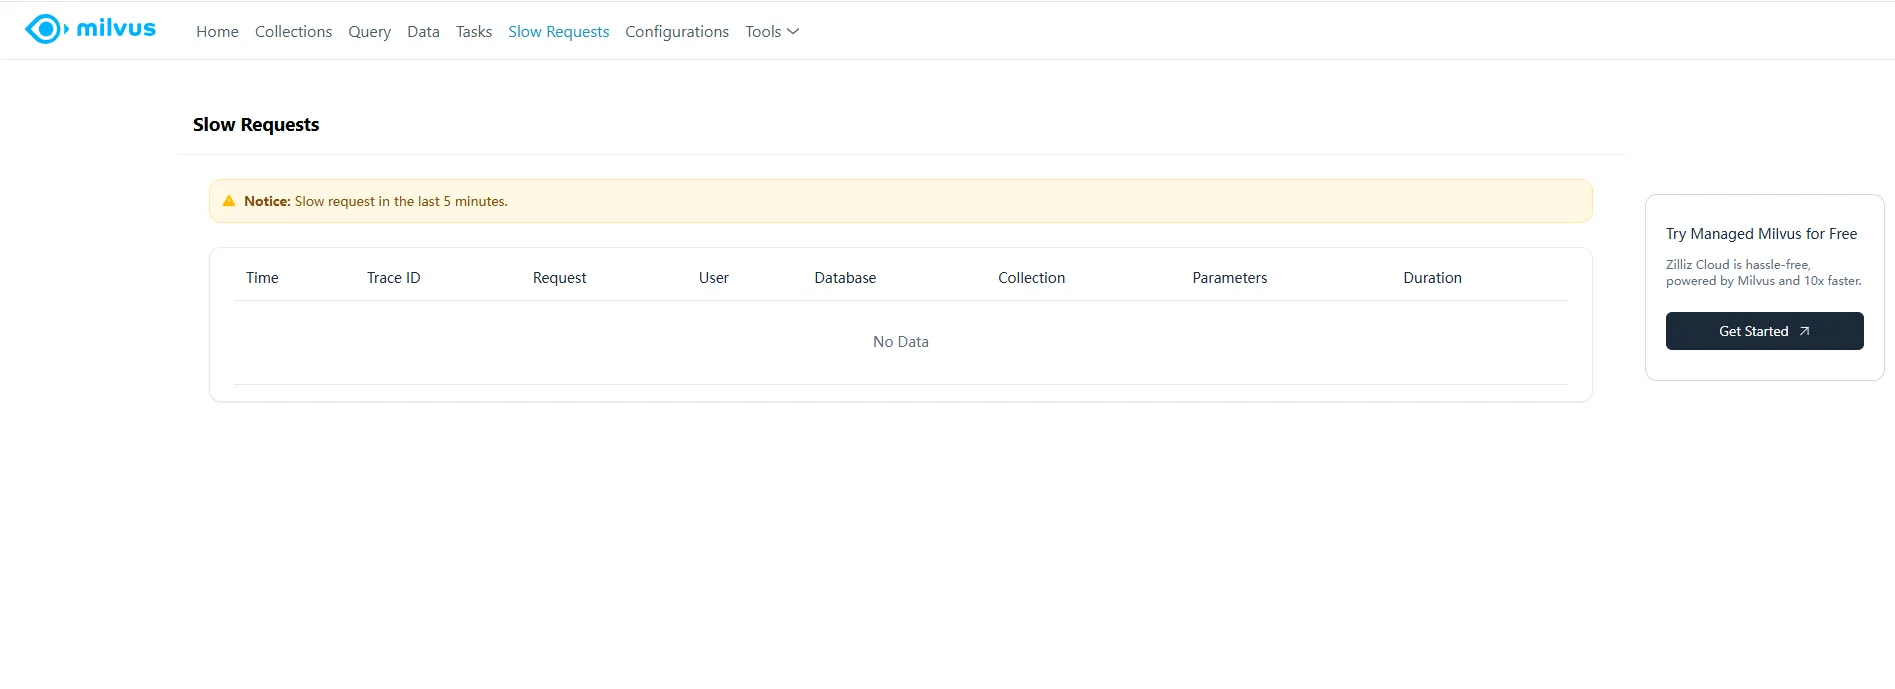

+ 在 Configurations 页面，可以查看 Milvus 运行时配置及其值的列表。
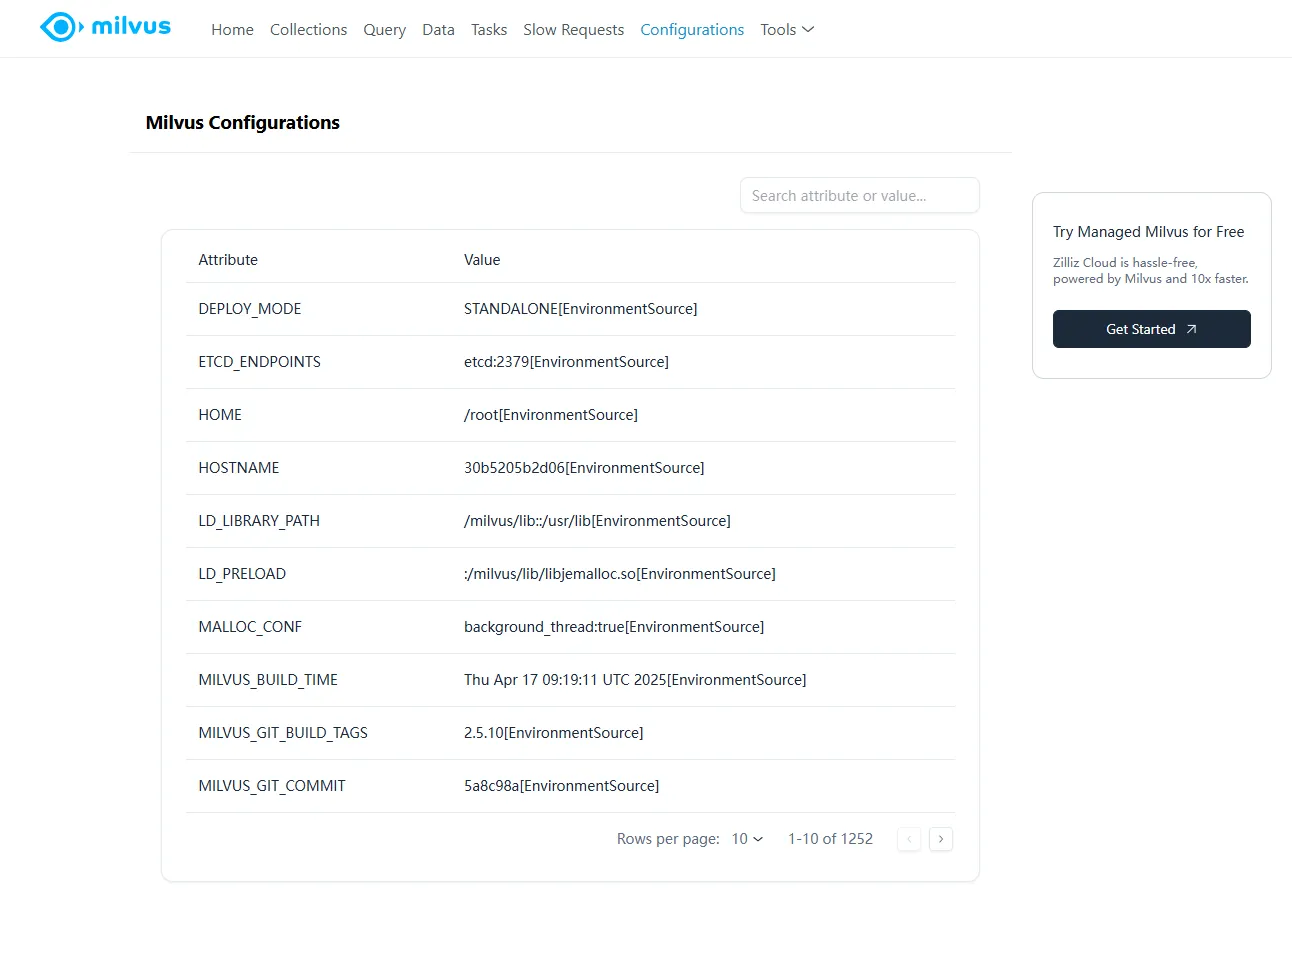

+ 在 Tools 页面，提供了 pprof 和 Milvus 数据可视化工具的链接。
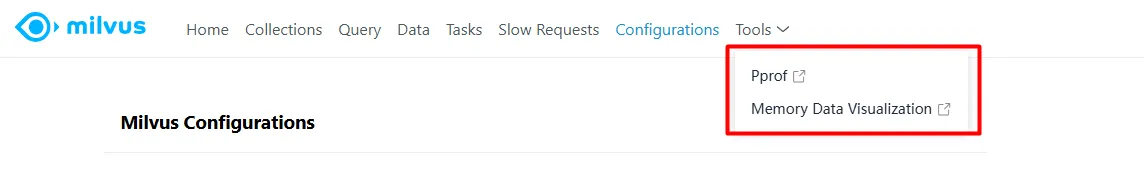

#### Attu 介绍
Attu 是 Milvus 向量数据库的官方可视化管理和运维工具，为用户提供图形化界面来操作和管理 Milvus 数据库。

1. 我们这里使用 docker 安装（更多安装方法参考[官网](https://github.com/zilliztech/attu?tab=readme-ov-file#installation-guides)） 
```bash
sudo docker run -p 8000:3000 -e MILVUS_URL=localhost:19530 zilliz/attu:v2.5
```
2. 浏览器访问 http://localhost:8000 来查看 Attu GUI
3. 点击连接

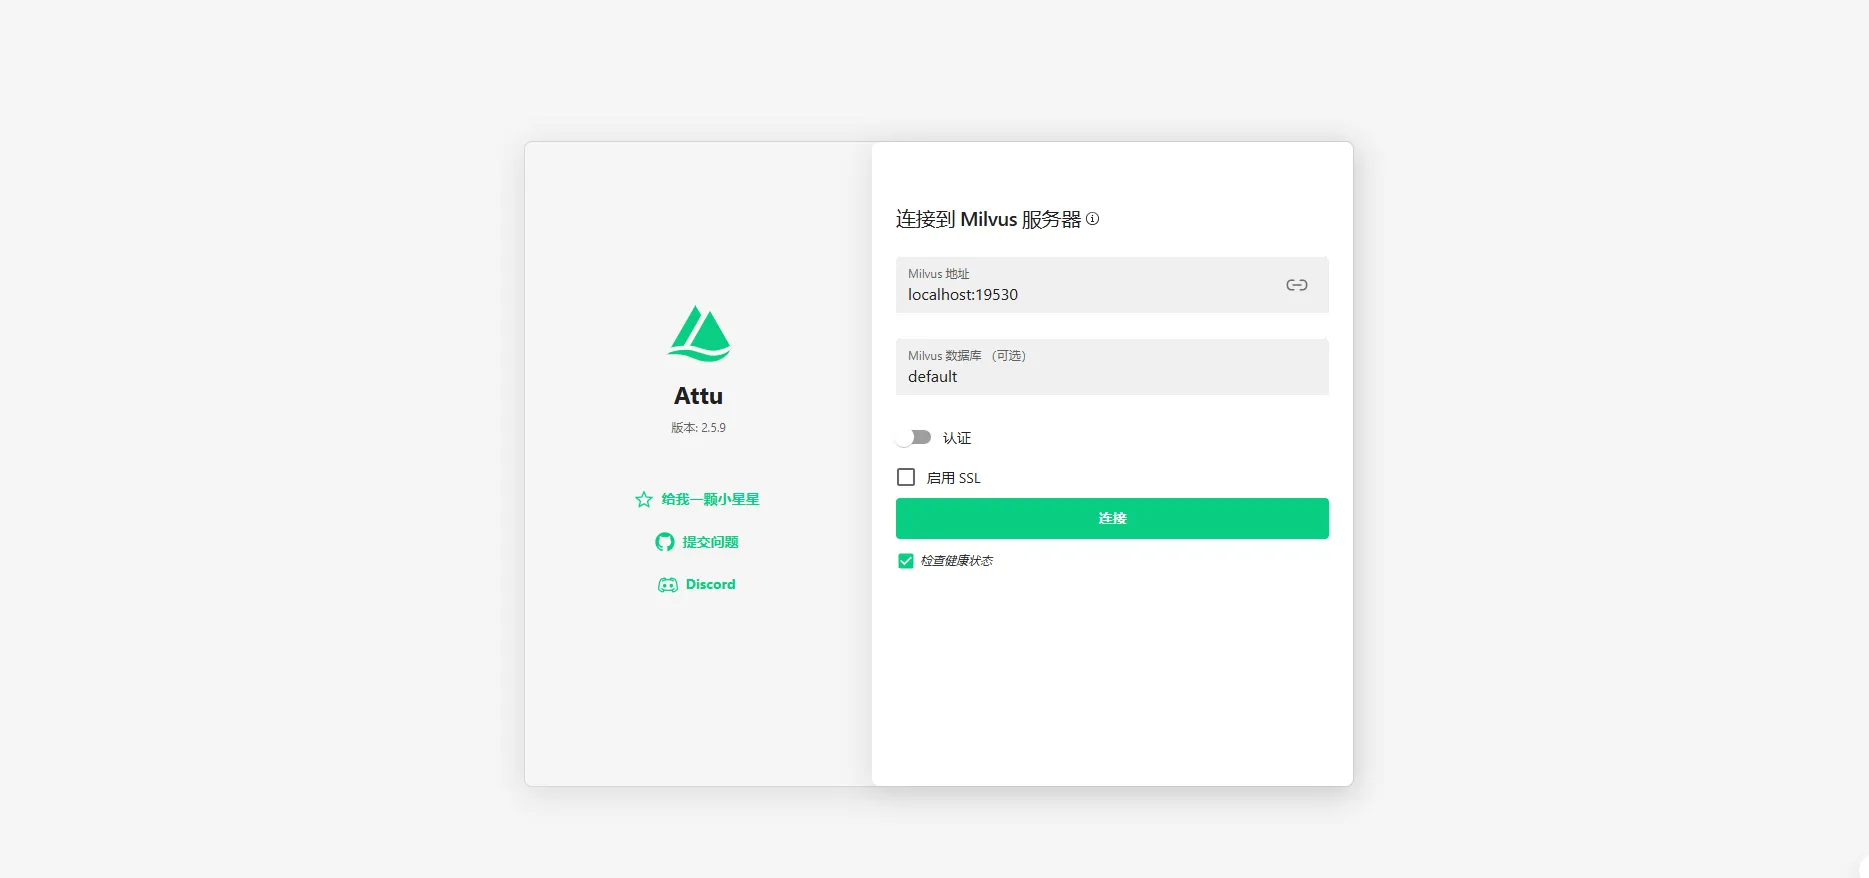
+ 主页

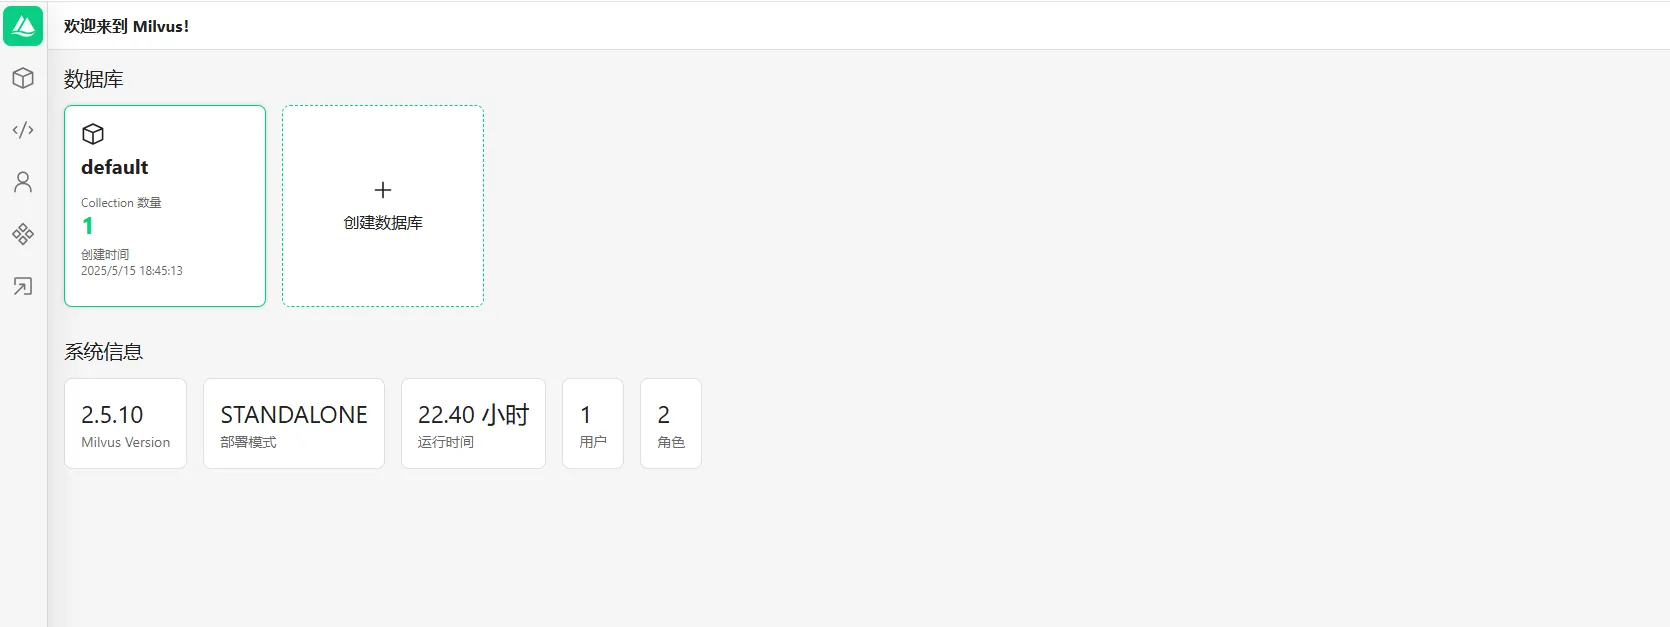
+ 数据库管理
    - 创建 Collection
      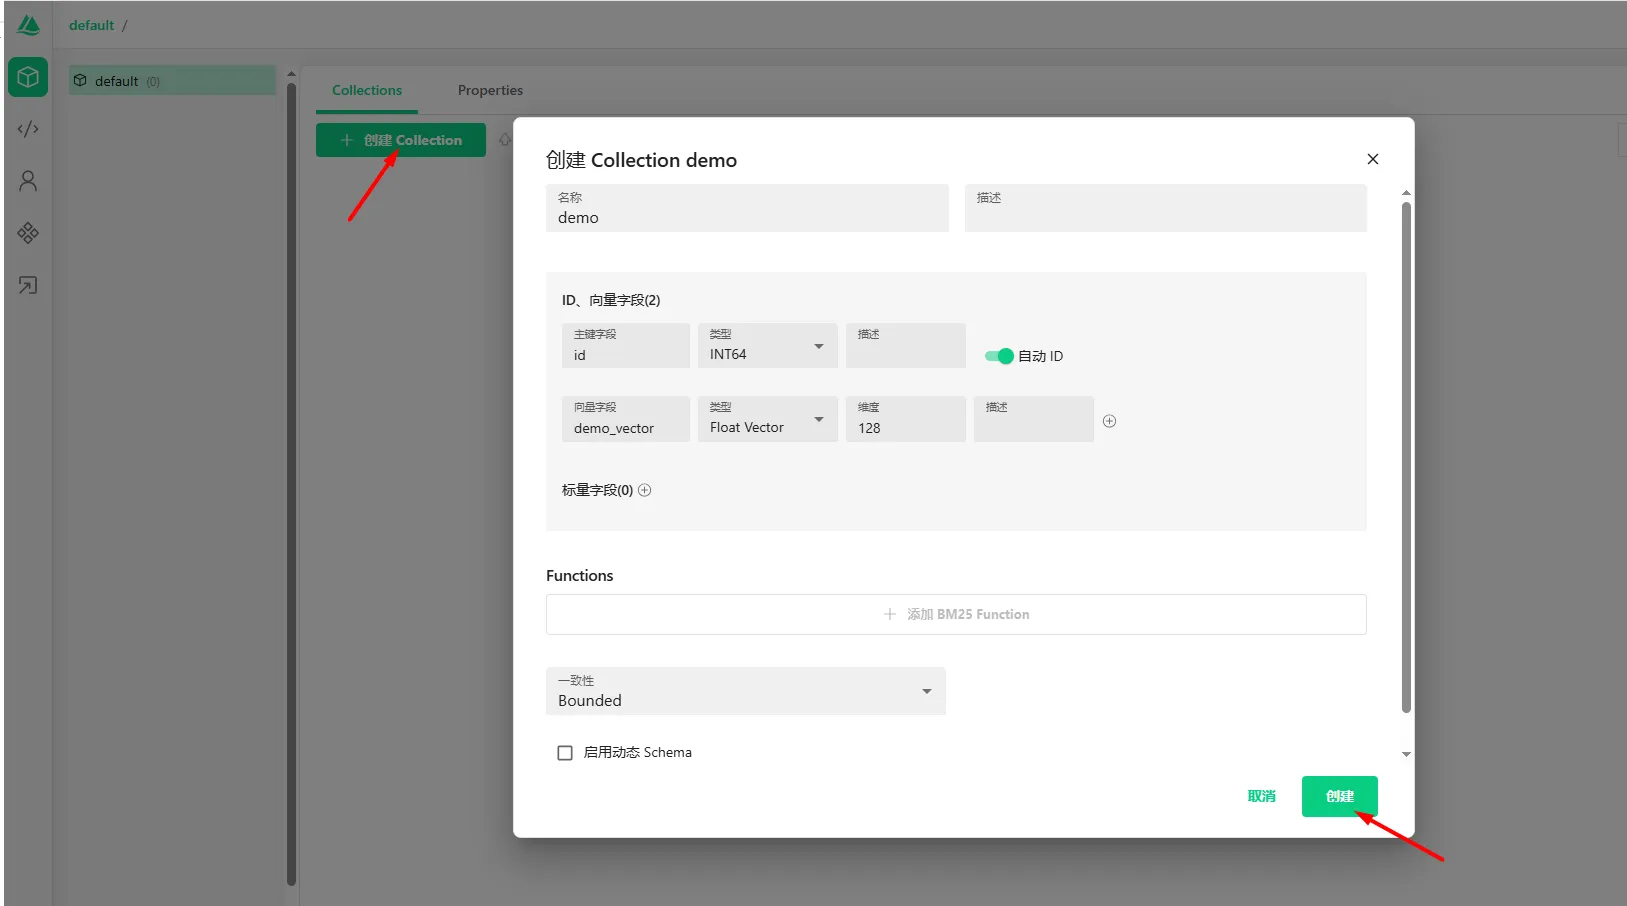
      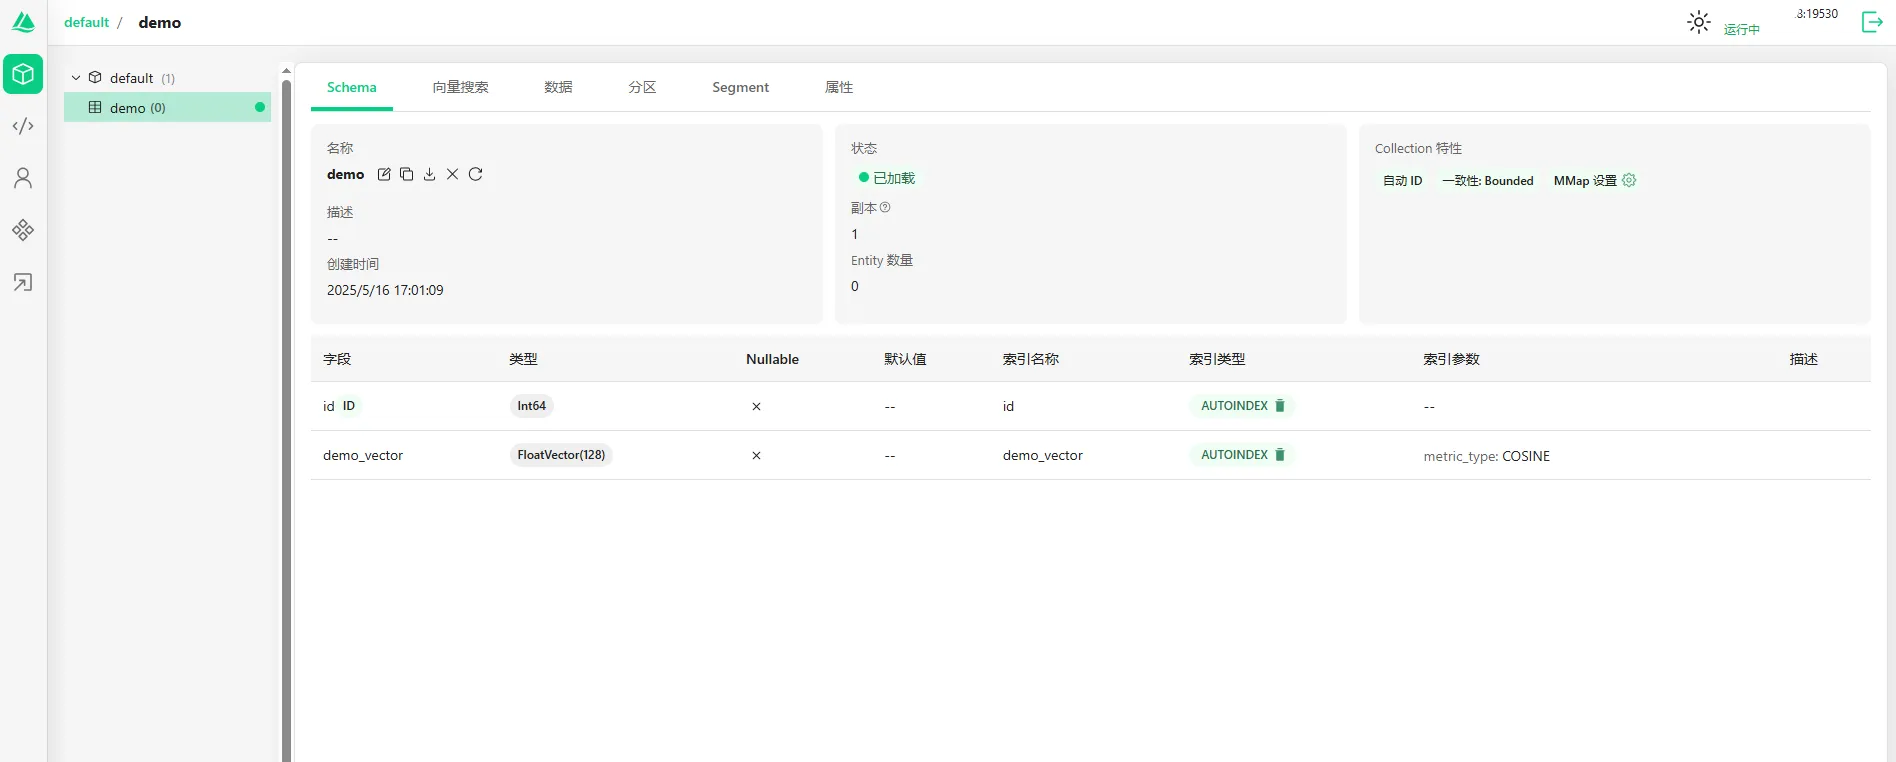
    - 导入数据
      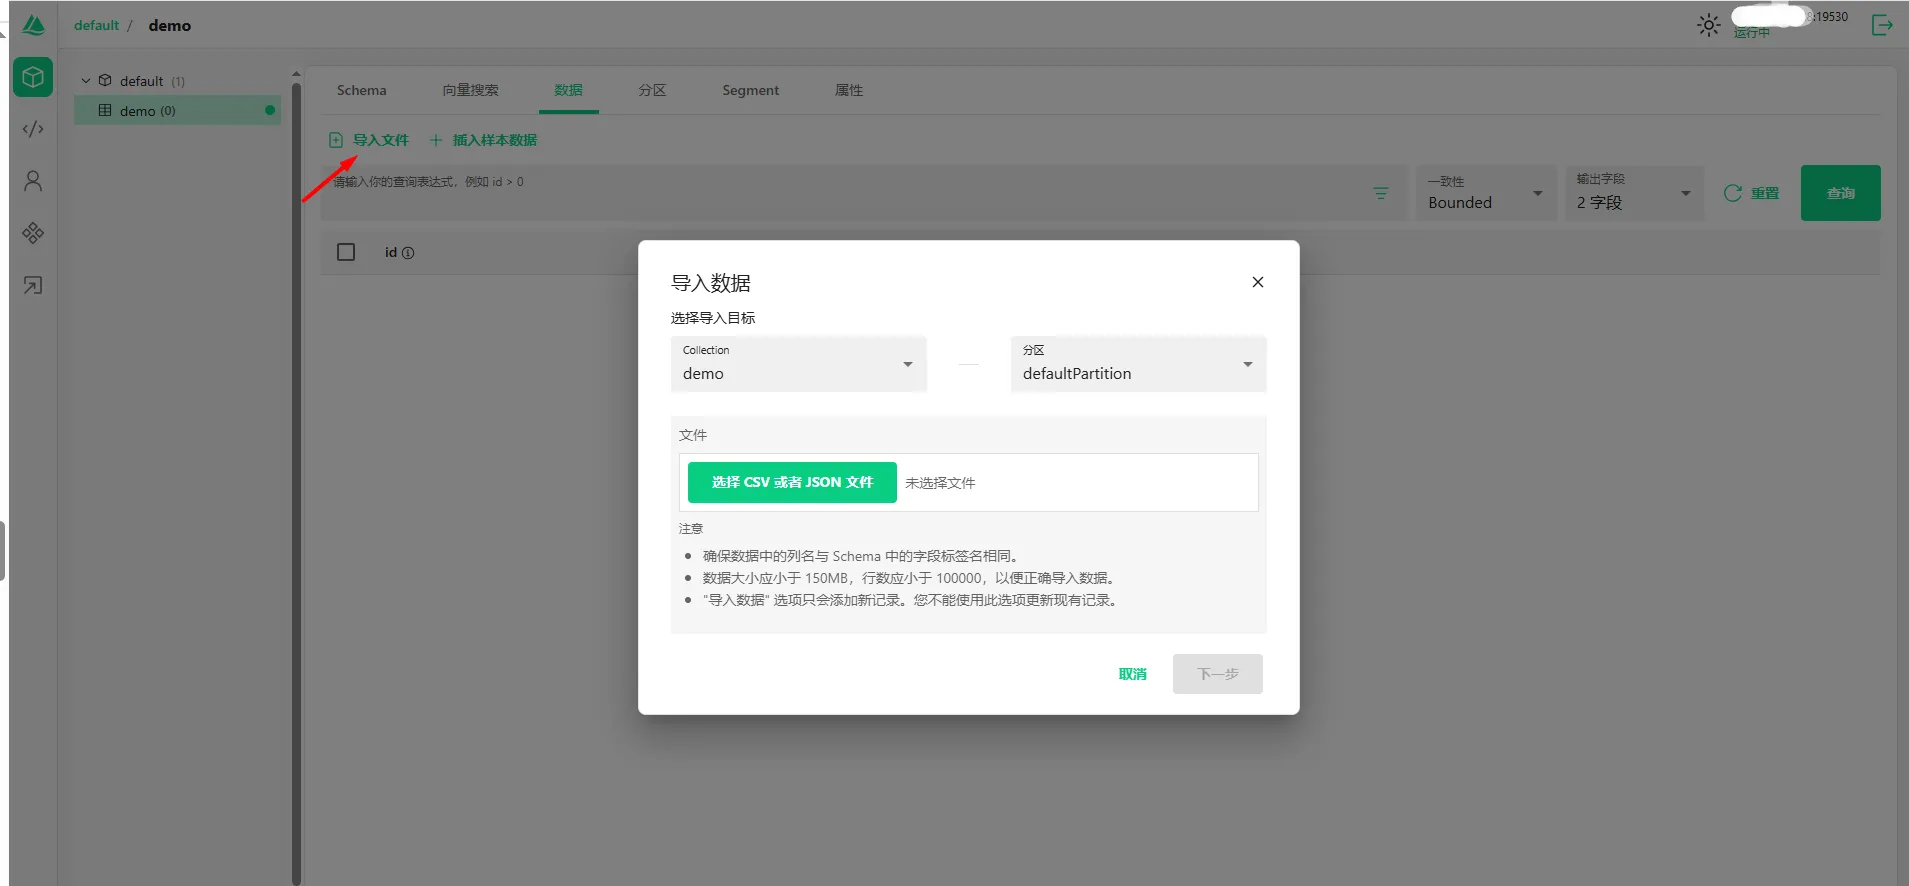
    - 向量搜索
      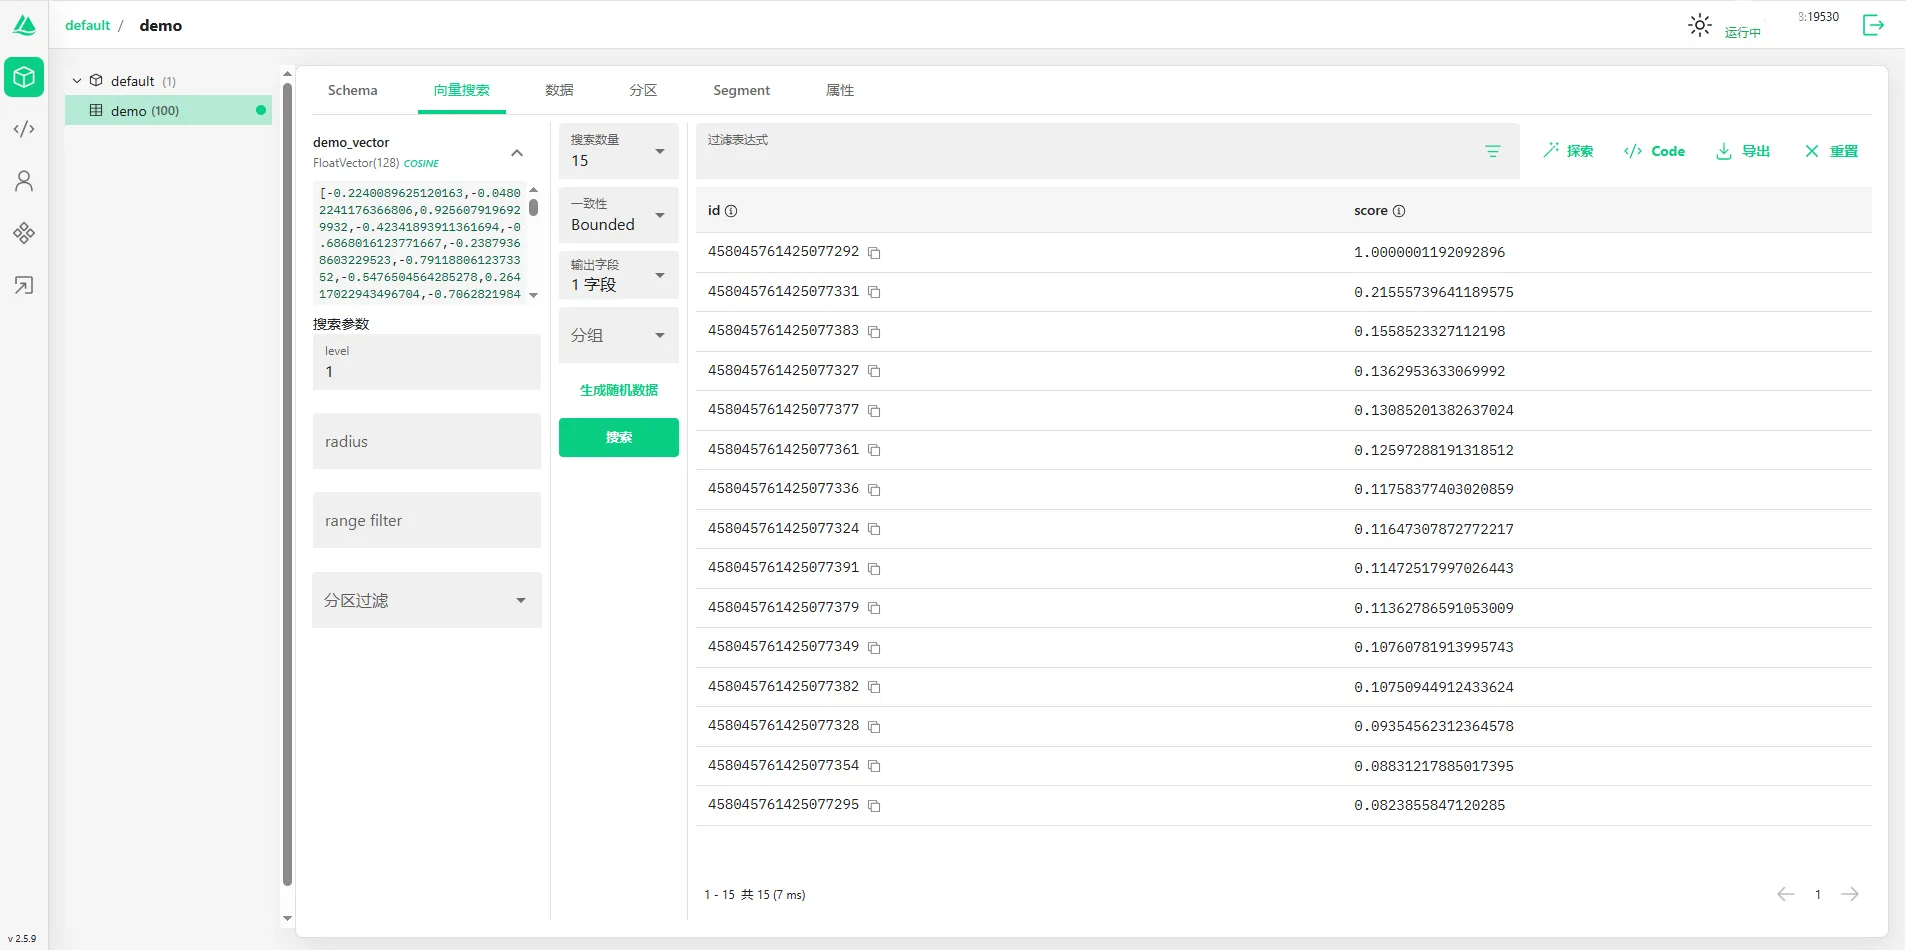
+ Play(beta)：是一个实验性功能，主要用于交互式查询和探索 Milvus 数据库。方便开发者快速测试 Milvus 的增删改查操作，也适合新手用户学习 Milvus 的 API 和查询语法。
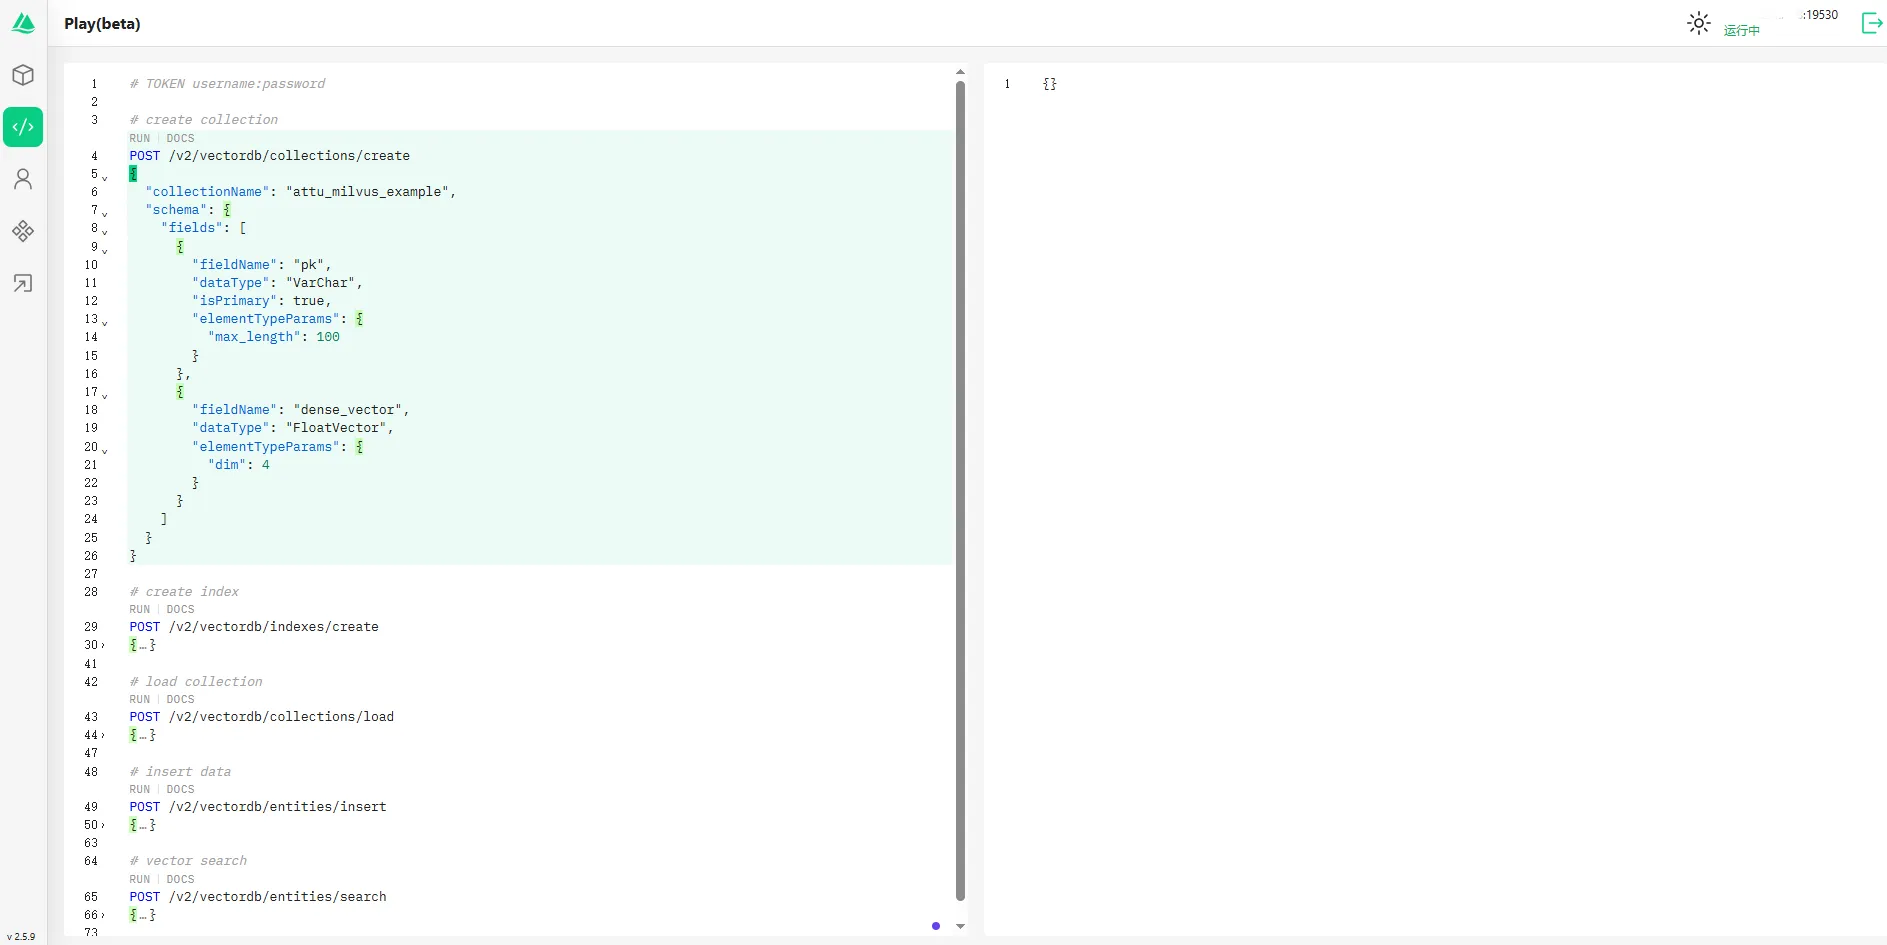
+ 用户和角色管理
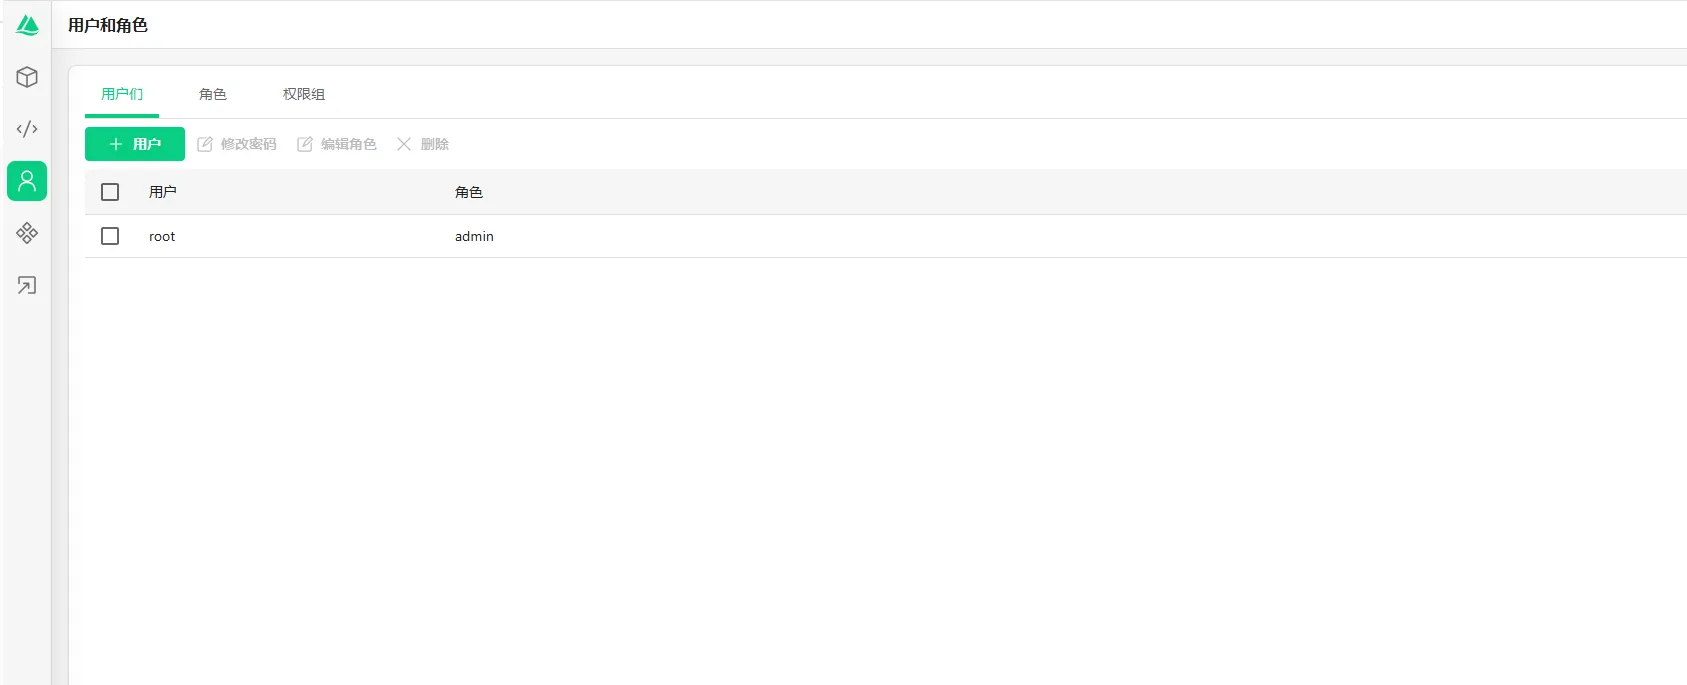
+ 系统视图
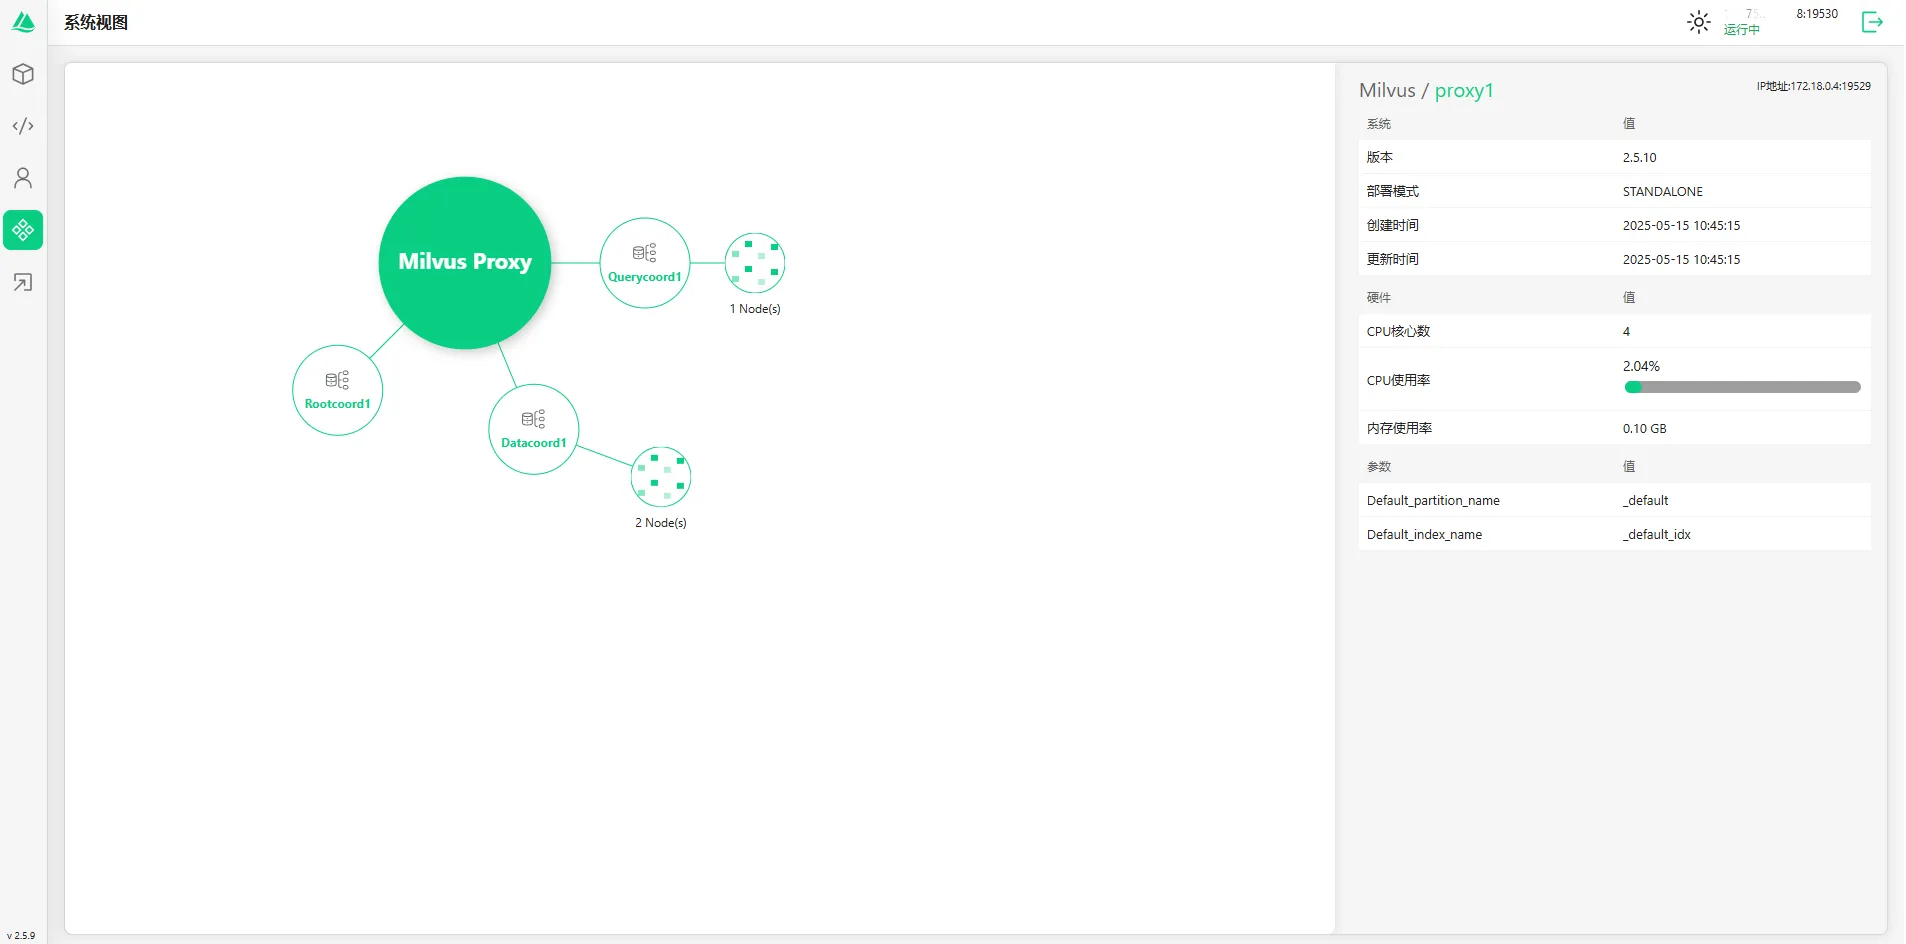